In [1]:
# Our numerical workhorse
import numpy as np
import scipy.special
import pandas as pd

# Import pyplot for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

# Import Bokeh modules for interactive plotting
import bokeh.charts
import bokeh.charts.utils
import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting

# Beeswarm plots
import beeswarm as bs

# Seaborn, useful for graphics
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

In [2]:
# load the data
df_aer = pd.read_csv('data/chure/20151001_aerobic_mean_intensities.csv', delimiter=',', comment='#')
df_anaer = pd.read_csv('data/chure/20151001_anaerobic_mean_intensities.csv', delimiter=',', comment='#')

#take a look at the data
df_aer.head()

,0 plasmids/cell,10^1 plasmids/cell,10^2 plasmids/cell,10^3 plasmids/cell,10^4 plasmids/cell,10^5 plasmids/cell
0,107.737249,105.097792,106.845238,104.485356,169.438242,111.046339
1,109.843794,102.075567,106.576923,104.136622,117.837283,215.607085
2,107.533228,102.937931,106.522358,105.623410,150.432234,115.541296
3,107.875289,103.765487,106.480663,104.078212,115.597059,141.717617
4,109.094017,105.121118,104.895810,102.788732,132.905286,107.345992


In [3]:
df_anaer.head()

,0 plasmids/cell,10^1 plasmids/cell,10^2 plasmids/cell,10^3 plasmids/cell,10^4 plasmids/cell,10^5 plasmids/cell
0,105.212500,104.238739,103.066667,102.989024,112.567732,108.008909
1,104.511254,103.918619,103.363229,103.045845,103.782544,104.361919
2,106.051625,103.953608,102.555035,103.908479,104.415214,104.712895
3,103.634241,103.371528,102.973529,103.535368,101.867410,177.966820
4,104.882897,104.415459,103.840746,103.622363,159.855365,104.092664


In [4]:
# Tidy data
df_aer.columns = (0, 1e1, 1e2, 1e3, 1e4, 1e5)
df_aer = pd.melt(df_aer, var_name='plasmids/cell', value_name='mean pixel intensity').dropna()
df_aer['aerobic'] = True

df_anaer.columns = (0, 1e1, 1e2, 1e3, 1e4, 1e5)
df_anaer = pd.melt(df_anaer, var_name='plasmids/cell', value_name='mean pixel intensity').dropna()
df_anaer['aerobic'] = False

df = df_aer
df = df.append(df_anaer)

In [5]:
# Check that we appended properly
df[df.aerobic==False].head()

,plasmids/cell,mean pixel intensity,aerobic
0,0,105.212500,False
1,0,104.511254,False
2,0,106.051625,False
3,0,103.634241,False
4,0,104.882897,False


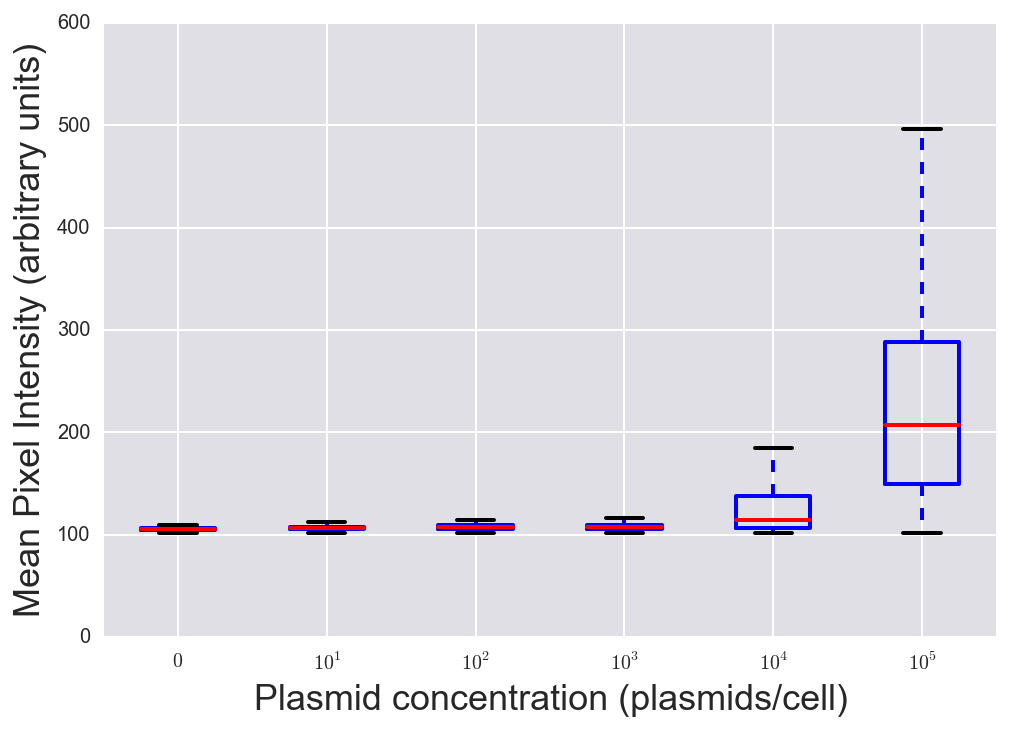

In [6]:
# Initial plots to get an idea what data looks like
data_to_plot = [df['mean pixel intensity'][(df['plasmids/cell']==0)],
                df['mean pixel intensity'][(df['plasmids/cell']==1e1)],
                df['mean pixel intensity'][(df['plasmids/cell']==1e2)],
                df['mean pixel intensity'][(df['plasmids/cell']==1e3)],
                df['mean pixel intensity'][(df['plasmids/cell']==1e4)],
                df['mean pixel intensity'][(df['plasmids/cell']==1e5)],]
_ = plt.boxplot(data_to_plot, labels=['$0$',
                                      '$10^1$',
                                      '$10^2$',
                                      '$10^3$',
                                      '$10^4$',
                                      '$10^5$'])
_ = plt.ylim((0,600))
_ = plt.xlabel('Plasmid concentration (plasmids/cell)')
_ = plt.ylabel('Mean Pixel Intensity (arbitrary units)')

In [7]:
# Couldn't get this to work
# _ = bs.beeswarm(data_to_plot)
# plt.grid(axis='x')
# plt.ylabel('$N_A$ (min)')
# plt.ylim((0, 60))

## Problem 3.1a
For each data set, compute the number of of transformed cells. You will have to decide on a criterion for what constitutes a transformed cell. Comment on how you decided on this criterion.

We have two options:
* A cell is transformed when it has an altered phenotype.
* A cell is transformed when it has an altered genotype.

Ultimately, we really want to know the second definition. If the cell has accepted at least one plasmid, even if it is not expressing the protein or very much of it, then it must have been competent and must have had a plasmid cross through its cell membrane, so it must have been transformed.

However, there is a problem with using this definition to separate our data set. We cannot directly observe whether the cell has had the plasmid added to it. All we can see is the phenotype (as measured by the mean pixel intensity of the bacterium).

Therefore, we must call cells transformed when they have an appreciably altered phenotype. There is a problem with this definition, too, though. We see from the initial plot of the data that the cells only really start to change appreciably change phenotype (expressing enough YFP to alter the mean pixel intensity) after $\approx 10^4$ plasmids are present in the cell. This is unsurprising, as if many plasmids are in the cell, much more protein will be expressed. We are trying to have a much more sensitive definition, though: we want to see a difference in phenotype when only a single YFP plasmid has been introduced. It will be difficult to choose an appropriate threshold.

To determine the threshold, we will compare the data from cells with zero plasmids and those with 10 plasmids. We know that cells with zero plasmids can not have been transformed, but that cells with greater than zero plasmids might have been. We hope that the phenotype of 10 plasmid cells is bimodal, then we can confidently say that the cells which have a greater mean intensity have been transformed.

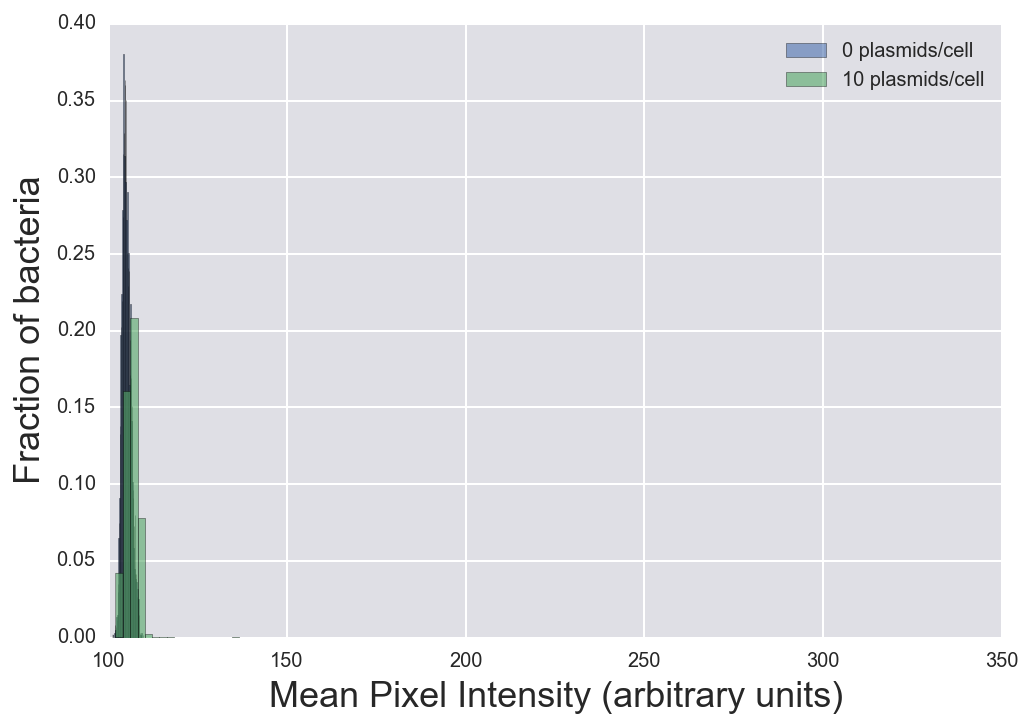

In [8]:
# Get number of bins (square root of number of data points)
nbins_0 = np.ceil(np.sqrt(len(df[(df.aerobic==False) & (df['plasmids/cell']==0)])))
nbins_1e1 = np.ceil(np.sqrt(len(df[(df.aerobic==False) & (df['plasmids/cell']==1e1)])))

_ = plt.hist(df['mean pixel intensity'][(df.aerobic==False) & (df['plasmids/cell']==0)].values,
             bins=nbins_0,
             normed=True, alpha=0.6)
_ = plt.hist(df['mean pixel intensity'][(df.aerobic==False) & (df['plasmids/cell']==1e1)].values,
             bins=nbins_1e1,
             normed=True, alpha=0.6)
_ = plt.ylabel('Fraction of bacteria')
_ = plt.xlabel('Mean Pixel Intensity (arbitrary units)')
_ = plt.legend(['0 plasmids/cell','10 plasmids/cell'])

Aha! This solves our problem. The mean pixel intensity has roughly the same distribution for both conditions, but 10 plasmids/cell has a very long tail, which 0 plasmids/cell does not. All bacteria in the tail are likely to have been transformed.

This is an example of why it is valuable to plot *all* the data, not just a summary plot such as the box plots above. (Unfortunately I could not get beeswarm to work, as it would be even clearer in that type of plot).

It is difficult to see in this plot, so let's zoom in on that long tail to see what's happening.

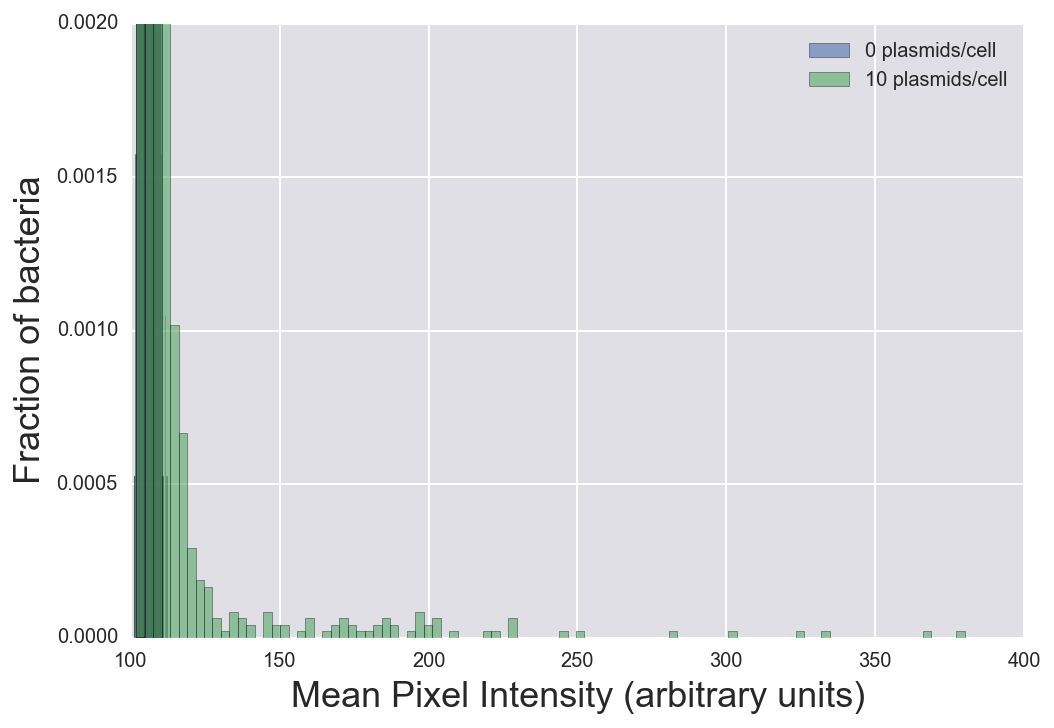

In [9]:
_ = plt.hist(df['mean pixel intensity'][(df['plasmids/cell']==0)].values,
             bins=nbins_0,
             normed=True, alpha=0.6)
_ = plt.hist(df['mean pixel intensity'][(df['plasmids/cell']==1e1)].values,
             bins=nbins_1e1,
             normed=True, alpha=0.6)
plt.ylim((0,0.002))
_ = plt.ylabel('Fraction of bacteria')
_ = plt.xlabel('Mean Pixel Intensity (arbitrary units)')
_ = plt.legend(['0 plasmids/cell','10 plasmids/cell'])

In [10]:
# Find maximum mean pixel intensity for the 0 plasmids/cell condition
max(df['mean pixel intensity'][(df['plasmids/cell']==0)])

111.99305555555556

In [11]:
transformed_threshold_125 = np.sum(df['mean pixel intensity'][(df['plasmids/cell']==1e1) &
                               (df['mean pixel intensity'] > 125)])
transformed_threshold_112 = np.sum(df['mean pixel intensity'][(df['plasmids/cell']==1e1) &
                               (df['mean pixel intensity'] > 112)])
print('Percentage of bacteria in 10 plasmids/cell condition with intensity\
      \ngreater than 112 which have intensity less than 125:\n', (transformed_threshold_112 - transformed_threshold_125)*100/transformed_threshold_112)

Percentage of bacteria in 10 plasmids/cell condition with intensity      
greater than 112 which have intensity less than 125:
 58.31381937462358


The tail is entirely from the experiment with 10 plasmids / cell. I am confident that all cells with a mean pixel intensity greater than $\approx125$ have been transformed (In fact, given that the tail is so variable, it might be that the cells with particularly high pixel intensity have accepted multiple plasmids and are expressing more of the gene).

However, I also expect that *most* cells with a mean pixel intensity greater than 112 (i.e. the maximum mean pixel intensity for the 0 plasmids/cell condition) are transformed. This means that if we used 125 as the threshold, we would miss at least 58% of the transformed bacteria, which is unacceptable.

There are two possible problems with using 112 as the threshold:
1. I am not sure that all of the cells with mean pixel intensity greater than 112 have been transformed (they could just be a particularly bright bacterium, and we happened not to see any that bright in the 0 plasmids/cell condition). It seems likely that most of them have been, however, so I am comfortable with the possible overestimation that this would cause.
2. It could be that some of the cells which have been transformed have a mean pixel intensity lower than 112 (if, for example, they are not expressing the protein very strongly). In fact, this seems likely, given that the 10 plasmids/cell condition has a larger fraction of its cells with intensities in the region 110-112 than the 0 plasmids/cell condition. Unfortunately, for an individual cell, we have no way to distinguish between the hypotheses "untransformed but high pixel intensity" and "transformed but low pixel intensity" until we have a more sophisticated model. Therefore I will use 112 as a tentative threshold, despite the probable underestimation of $n_t$ that this causes.

In [12]:
def transformed_cells(df, aerobic, concentration=False):
    """
    Return number of transformed cells and total number of cells.
    """
    if concentration:
        inds = (df['aerobic'] == aerobic) & (df['plasmids/cell'] == concentration)
    else:
        inds = (df['aerobic'] == aerobic)
    n_t = df[inds]['transformed'].sum()
    n = df[inds]['transformed'].count()
    
    return n_t, n

df['transformed'] = (df['mean pixel intensity'] > 112)
print('Number of transformed cells in aerobic condition:',transformed_cells(df, True)[0])
print('Number of transformed cells in anaerobic condition:',transformed_cells(df, False)[0])

Number of transformed cells in aerobic condition: 7314
Number of transformed cells in anaerobic condition: 1925


There are many more transformed cells in the aerobic condition. We can't interpret this on its own, because we don't know how many cells total there are in each condition (I expect that there are many fewer cells in the anaerobic condition):

In [13]:
print('Percentage of transformed cells in aerobic condition:',100*transformed_cells(df, True)[0]/transformed_cells(df, True)[1])
print('Percentage of transformed cells in anaerobic condition:',100*transformed_cells(df, False)[0]/transformed_cells(df, False)[1])

Percentage of transformed cells in aerobic condition: 18.77165516
Percentage of transformed cells in anaerobic condition: 6.90558186253


We still haven't adjusted for the number of cells in each DNA concentration (if many more cells grew in high DNA concentrations for the aerobic condition, for example, this would throw off our results) but we get an idea that cells are more likely to transform when they are grown aerobically.

**b)** For each plasmid concentration, compute and plot the posterior distribution, $P(p\mid n_t, n, I)$, where $n_t$ out of $n$ cells are determined to have been transformed, and $p$ is the probability that any given cell is transformed.  Do this for both the anaerobic and aerobic data sets.

### Start with Bayes' Theorem:

$\text{P}(p\mid n_t, n, I) = \frac{\text{P}(n_t\mid p,n,I)\text{P}(p\mid n,I)}{\text{P}(n_t\mid n,I)}$

### Likelihood:
This is a binomially distributed data set, analogous to the worm data from tutorial 3b. Therefore our likelihood is the binomial distribution.

$\text{P}(p\mid n_t, n, I) = \frac{n!}{(n-n_t)!n_t!}p^{n_t}(1-p)^{n-n_t}$

### Prior:
We are maximally ignorant, we expect p to be uniformly distributed between 0 and 1.
Therefore our prior is:

$\text{P}(p\mid n,I) = \left\{
\begin{array}{c l}      
    1 & 0\leq p\leq 1\\
    0 & \text{otherwise}
\end{array}\right.$

### Evidence / marginalised likelihood:
Before we see the results of the experiment, the number of transformed cells could be anything from $0$ to $n$. The probability is equally distributed between all of these possibilities. So:

$\text{P}(n_t\mid n) = \frac{1}{n+1}$

### Overall:

$\text{P}(p\mid n_t, n, I) = \left\{
\begin{array}{c l}      
    \frac{(n+1)!}{(n-n_t)!n_t!}p^{n_t}(1-p)^{n-n_t} & 0\leq p\leq 1\\
    0 & \text{otherwise}
\end{array}\right.$

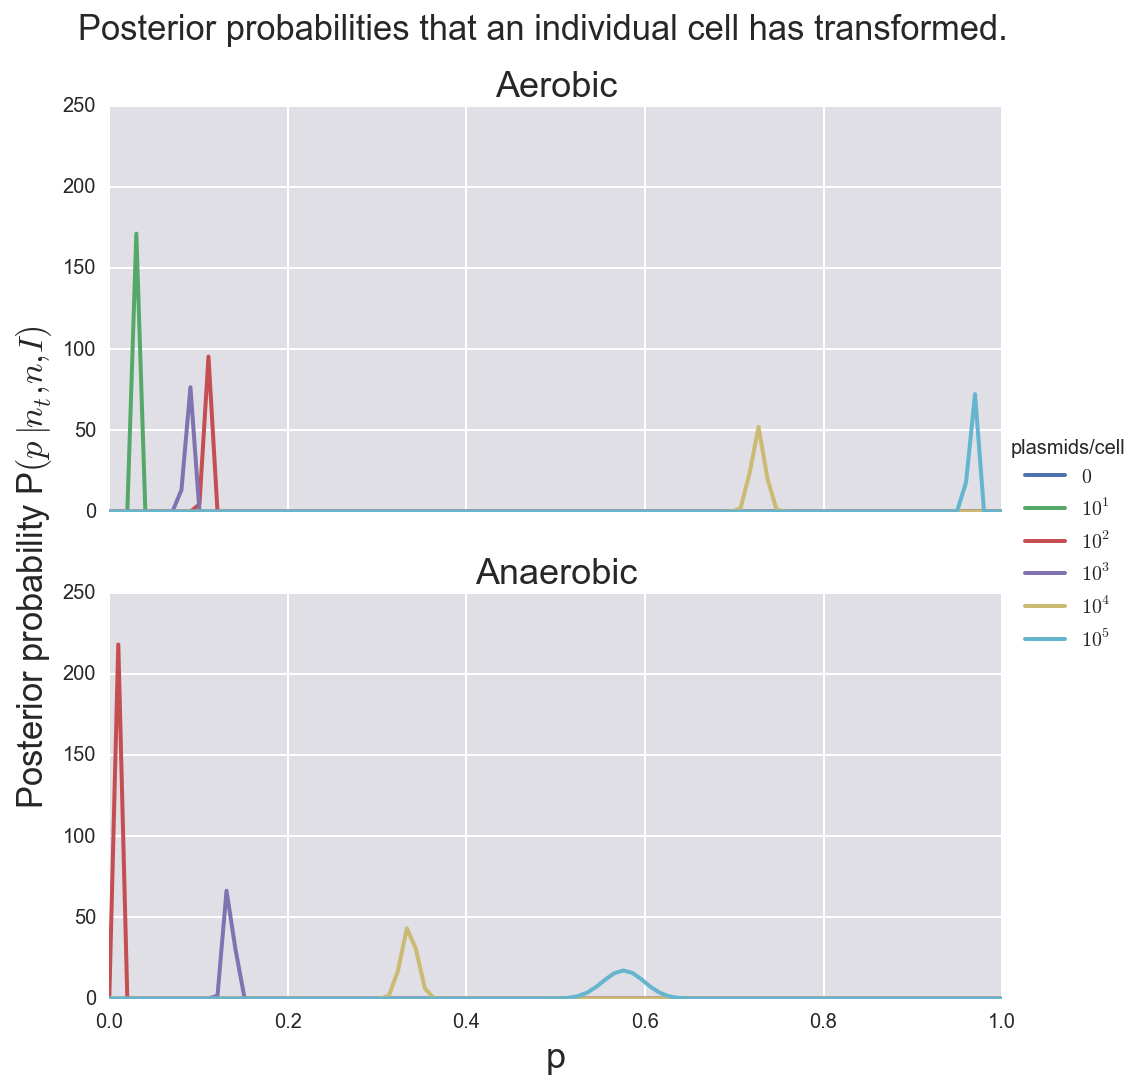

In [14]:
def binomial_posterior(p, n_t, n):
    """
    Returns posterior probability for a binomial distribution given p, n_t and n.
    It would be easier not to break the parts up, but this way makes it clear what
    the function is doing, exactly.
    However, we are likely to get overflows if we actually try to calculate it this way.
    """
#     if (p < 0) | (p > 1):
#         prior = 1
#     else:
#         prior = 0
#         return 0
    prior = 1
    likelihood = np.math.factorial(n)/(np.math.factorial(n-n_t)*np.math.factorial(n_t))
    evidence = 1/(n+1)
    return likelihood*prior/evidence

def log_binomial_posterior(p, n_t, n):
    """
    Returns log of posterior probability for a binomial distribution given p, n_t and n.
    """
    return scipy.special.gammaln(n+2) - scipy.special.gammaln(n_t + 1) \
              - scipy.special.gammaln(n - n_t + 1) \
              + n_t * np.log(p) + (n - n_t) * np.log(1 - p)

posteriors = pd.DataFrame()
for j in [0, 1e1, 1e2, 1e3, 1e4, 1e5]:
    for aerobic in (True, False):
        p_range = np.linspace(0,1,100)
        posteriors_temp = pd.DataFrame([p_range])
        posteriors_temp = posteriors_temp.transpose()
        posteriors_temp.columns = ['p']
        posteriors_temp['posterior'] = 0
        posteriors_temp['plasmids/cell'] = j
        if aerobic==True:
            posteriors_temp['aerobic'] = True
        else:
            posteriors_temp['aerobic'] = False
        n_t = len(df[(df['aerobic']==aerobic) & (df['transformed']) & (df['plasmids/cell']==j)])
        n = len(df[(df['aerobic']==aerobic) & (df['plasmids/cell']==j)])
        for i, p in enumerate(posteriors_temp.p):
            posteriors_temp.loc[i,'posterior'] = np.exp(log_binomial_posterior(p, n_t, n))
        posteriors = posteriors.append(posteriors_temp)

# Create subplots (ax is array of axis objects)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), sharex=True, sharey=True)

linelist_aer = []
for j in [0, 1e1, 1e2, 1e3, 1e4, 1e5]:
    inds = ((posteriors['plasmids/cell']==j) & (posteriors['aerobic']==True))
    linelist_aer += ax[0].plot(posteriors[inds]['p'],
                 posteriors[inds]['posterior'])
    
    inds = ((posteriors['plasmids/cell']==j) & (posteriors['aerobic']==False))
    _ = ax[1].plot(posteriors[inds]['p'],
                 posteriors[inds]['posterior'])
plt.figlegend(linelist_aer, ['$0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$'], loc='right', title='plasmids/cell', borderaxespad=0.)
ax[0].set_title('Aerobic')
ax[1].set_title('Anaerobic')
fig.suptitle('Posterior probabilities that an individual cell has transformed.', size='xx-large')

plt.xlabel('p')
# Cannot use plt.ylabel, this only labels the bottom subplot
fig.text(0.06, 0.5, 'Posterior probability P$(p\mid n_t, n, I)$', ha='center', va='center', rotation='vertical', size='xx-large')
                                    

I found out how to label y axis of both plots here:
http://stackoverflow.com/questions/6963035/pyplot-axes-labels-for-subplots

I found out how to assign individual items in an existing Pandas DataFrame here: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

I found out how to create a single legend for multiple subplots here: http://stackoverflow.com/questions/9834452/how-do-i-make-a-single-legend-for-many-subplots-with-matplotlib

Strangely, for the aerobic condition, p\* is lower for the 1000 plasmids/cell condition than the 100 plasmids/cell condition. Let's check this against the percentages:

In [15]:
print('Percentage of transformed cells for aerobic 100 plasmids/cell condition:', 100*transformed_cells(df, True, 100)[0]/transformed_cells(df, True, 100)[1])
print('Percentage of transformed cells for aerobic 1000 plasmids/cell condition:', 100*transformed_cells(df, True, 1000)[0]/transformed_cells(df, True, 1000)[1])

Percentage of transformed cells for aerobic 100 plasmids/cell condition: 10.8657161495
Percentage of transformed cells for aerobic 1000 plasmids/cell condition: 8.77370783263


OK, this agrees. It's just a strange quirk of the data.

The other thing we can see about the graph is that some of the lines seem to be missing. This is probably because p\* for those lines is too low, so we can't see the peak at this resolution. Let's check that:

In [16]:
transformed_cells(df, False, 10)

(17, 9483)

There are only 17 transformed cells out of 9483 total cells in the anaerobic, 10 plasmids/cell condition, and no transformed cells in the 0 plasmid/cell conditions so it is unsurprising that p\* is close enough to zero that it cannot be seen on the plot for these conditions.

Let's zoom in close to p=0: 

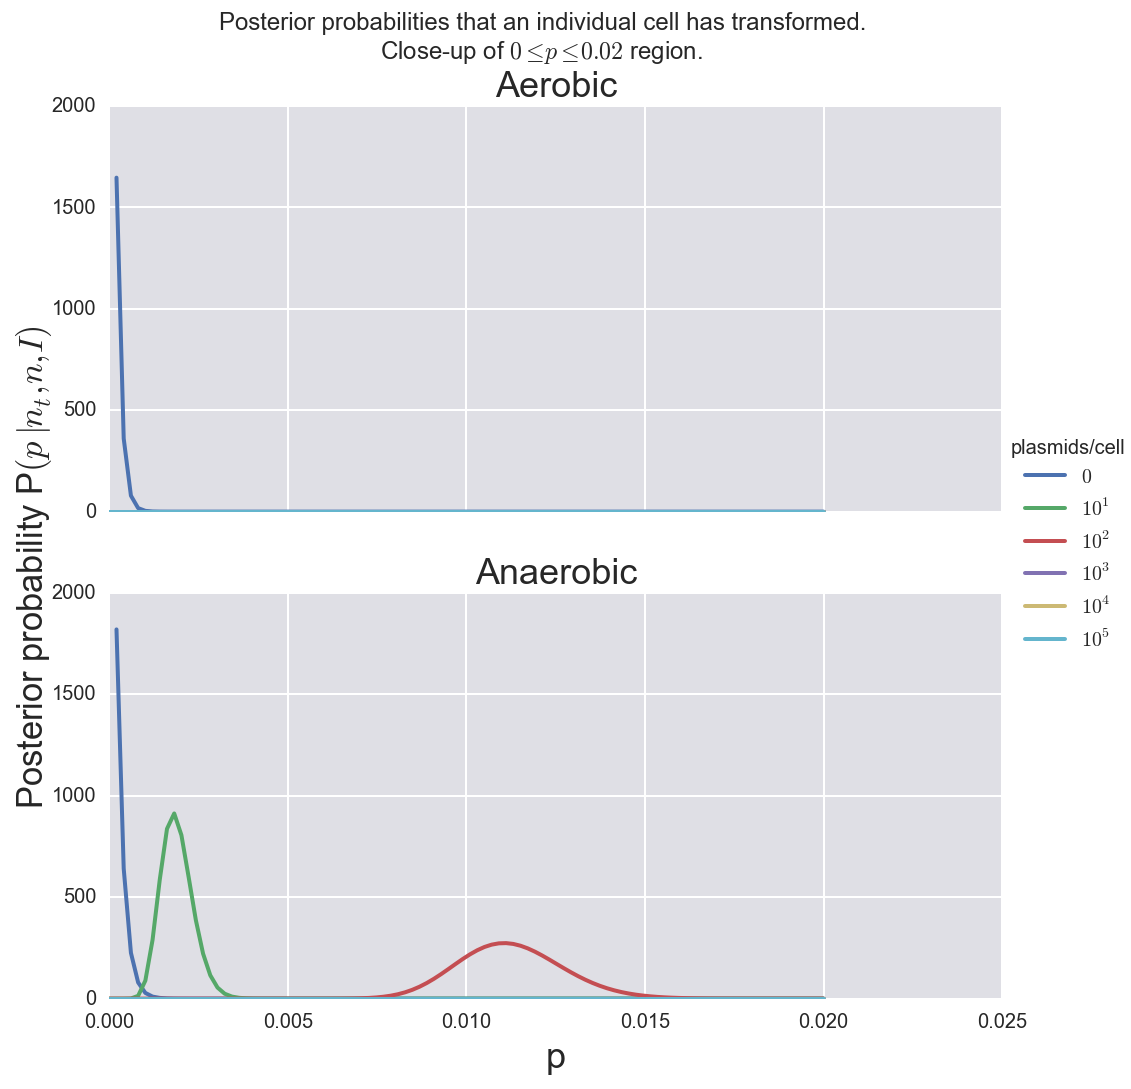

In [17]:
posteriors = pd.DataFrame()
for j in [0, 1e1, 1e2, 1e3, 1e4, 1e5]:
    for aerobic in (True, False):
        p_range = np.linspace(0,0.02,100)
        posteriors_temp = pd.DataFrame([p_range])
        posteriors_temp = posteriors_temp.transpose()
        posteriors_temp.columns = ['p']
        posteriors_temp['posterior'] = 0
        posteriors_temp['plasmids/cell'] = j
        if aerobic==True:
            posteriors_temp['aerobic'] = True
        else:
            posteriors_temp['aerobic'] = False
        n_t = len(df[(df['aerobic']==aerobic) & (df['transformed']) & (df['plasmids/cell']==j)])
        n = len(df[(df['aerobic']==aerobic) & (df['plasmids/cell']==j)])
        for i, p in enumerate(posteriors_temp.p):
            posteriors_temp.loc[i,'posterior'] = np.exp(log_binomial_posterior(p, n_t, n))
        posteriors = posteriors.append(posteriors_temp)

# Create subplots (ax is array of axis objects)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), sharex=True, sharey=True)        

linelist_aer = []
for j in [0, 1e1, 1e2, 1e3, 1e4, 1e5]:
    inds = ((posteriors['plasmids/cell']==j) & (posteriors['aerobic']==True))
    linelist_aer += ax[0].plot(posteriors[inds]['p'],
                 posteriors[inds]['posterior'])
    
    inds = ((posteriors['plasmids/cell']==j) & (posteriors['aerobic']==False))
    _ = ax[1].plot(posteriors[inds]['p'],
                 posteriors[inds]['posterior'])
plt.figlegend(linelist_aer, ['$0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$'], loc='right', title='plasmids/cell', borderaxespad=0.)
ax[0].set_title('Aerobic')
ax[1].set_title('Anaerobic')
fig.suptitle('Posterior probabilities that an individual cell has transformed.\nClose-up of $0\leq p\leq 0.02$ region.', size='large')

plt.xlabel('p')
# Cannot use plt.ylabel, this only labels the bottom subplot
fig.text(0.06, 0.5, 'Posterior probability P$(p\mid n_t, n, I)$', ha='center', va='center', rotation='vertical', size='xx-large')
                              

As expected, p\* is zero when plasmids/cell is zero, and very close to zero when plasmids/cell is low. This agrees with our intuition.

Otherwise, this all looks good: The most likely p is generally larger for greater concentrations of DNA, and larger for the aerobic condition for any given concentration.